# Plot diagrams


In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import re

In [2]:
metric_file_path = "../runs/metrics.txt"
x_value_order = ["1", "3", "10", "30", "All"] # , "100"
x_axis_title = "N.o. samples per class"
y_axis_title = "Macro F1 score"
score_column = "f1_macro"


aggregating_configs = {
    "Random": r"(?i)random_.+",
    "ImageNet SL V1": r"(?i)imagenet_v1",
    "ImageNet SL V2": r"(?i)imagenet_v2",
    "ImageNet SL V3": r"(?i)imagenet_v3",
    "ImageNet SSL": r"(?i)imagenet_ssl",
    "PDDD": r"(?i)pddd.*",
}

architecture_configs = {"ResNet50": r"ResNet50", "ViT Base": r"ViT_B16"}
model_configs = {"KNN": r"knn", "Linear regression": r"lr"}
dataset_configs = {"Cassava mini": r"Cassava_Mini", "PlantDoc": r"PlantDoc"}

In [3]:
def number_to_string(value):
    if value == value:
        return str(int(value))
    else:  # NaN
        return "All"

In [4]:
metric_file = open(metric_file_path, "r")
content = metric_file.read().replace("\n", "").replace("}{", "},{")
entries = json.loads("[" + content + "]")
print(f"Read {len(entries)} entries")

Read 2624 entries


In [5]:
df = pd.DataFrame.from_records(entries)
df["number_of_samples"] = df["number_of_samples"].apply(number_to_string)
print(df.columns)

Index(['model_name', 'feature_identifier', 'number_of_samples',
       'selection_seed', 'accuracy', 'balanced_accuracy', 'f1_weighted',
       'f1_micro', 'f1_macro'],
      dtype='object')


In [6]:
total_counter = 0
for key in model_configs:
    model_name = model_configs[key]
    number_of_matching_rows = df["model_name"].str.contains(model_name).sum()
    print(f"{key} -> {number_of_matching_rows} matches")
    total_counter += number_of_matching_rows

print(f"{len(df)} == {total_counter}")
assert len(df) == total_counter

KNN -> 1312 matches
Linear regression -> 1312 matches
2624 == 2624


In [7]:
total_counter = 0
for key in dataset_configs:
    dataset_name = dataset_configs[key]
    number_of_matching_rows = df["feature_identifier"].str.contains(dataset_name).sum()
    print(f"{key} -> {number_of_matching_rows} matches")
    total_counter += number_of_matching_rows

print(f"{len(df)} == {total_counter}")
assert len(df) == total_counter

Cassava mini -> 1312 matches
PlantDoc -> 1312 matches
2624 == 2624


In [8]:
total_counter = 0
for key in architecture_configs:
    architecture = architecture_configs[key]
    number_of_matching_rows = df["feature_identifier"].str.contains(architecture).sum()
    print(f"{key} -> {number_of_matching_rows} matches")
    total_counter += number_of_matching_rows

print(f"{len(df)} == {total_counter}")
assert len(df) == total_counter

ResNet50 -> 1148 matches
ViT Base -> 1476 matches
2624 == 2624


In [9]:
total_counter = 0
for label in aggregating_configs:
    number_of_matching_rows = (
        df["feature_identifier"].str.contains(aggregating_configs[label]).sum()
    )
    print(f"{label} -> {number_of_matching_rows} matches")
    total_counter += number_of_matching_rows

print(f"{len(df)} == {total_counter}")
assert len(df) == total_counter

Random -> 984 matches
ImageNet SL V1 -> 328 matches
ImageNet SL V2 -> 328 matches
ImageNet SL V3 -> 164 matches
ImageNet SSL -> 328 matches
PDDD -> 492 matches
2624 == 2624


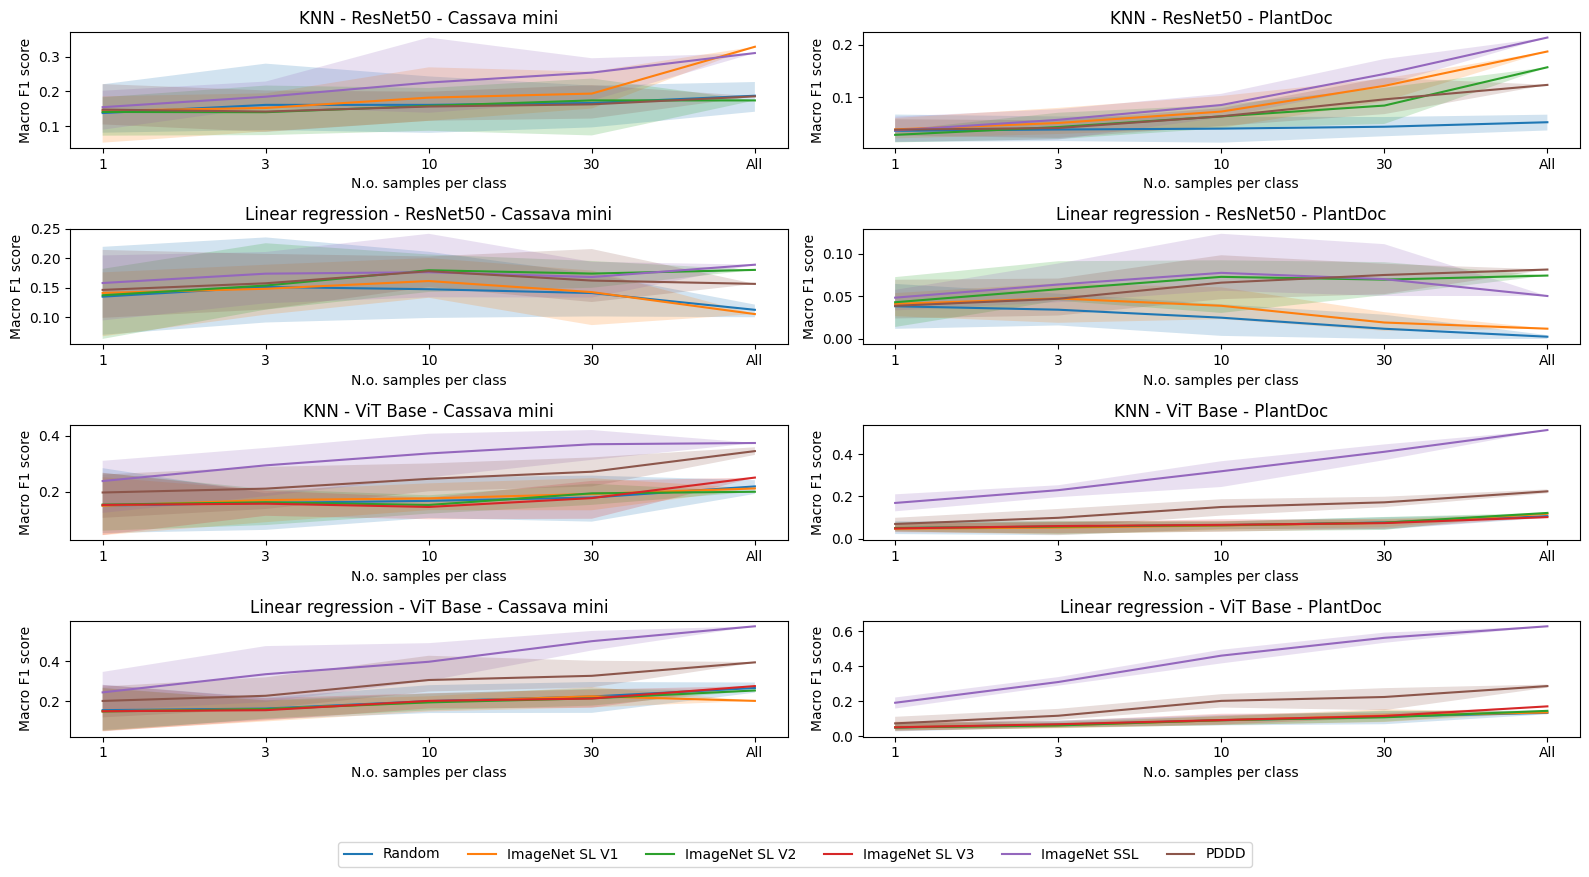

In [10]:
fig, ax = plt.subplots(len(architecture_configs) * len(model_configs), len(dataset_configs), figsize=(16, 8))

for row_1, arch_key in enumerate(architecture_configs):
    architecture = architecture_configs[arch_key]
    df_arch = df[df["feature_identifier"].str.contains(architecture)]

    for label in aggregating_configs:
        df_agg = df_arch[df_arch["feature_identifier"].str.contains(aggregating_configs[label])]

        for column, dataset_key in enumerate(dataset_configs):
            dataset = dataset_configs[dataset_key]
            df_data = df_agg[df_agg["feature_identifier"].str.contains(dataset)]
            
            for row_2, model_key in enumerate(model_configs):
                model_name = model_configs[model_key]
                row = row_1 * len(model_configs) + row_2

                df_model = df_data[df_data["model_name"].str.contains(model_name)]

                df_val = df_model.groupby(["number_of_samples"]).agg({"f1_macro": ["mean", "min", "max"]})
                df_val.columns = df_val.columns.droplevel(0)
                df_val = df_val.reset_index()
                df_val.set_index("number_of_samples", inplace=True)
                df_val = df_val.reindex(index=x_value_order)

                ax[row][column].fill_between(
                    df_val.index, df_val["min"], df_val["max"], alpha=0.2
                )
                # ax[row][column].plot(df_val["mean"], linestyle='dashed',label=label) # ,label=[label]
                df_val.plot.line(
                    ax=ax[row][column],
                    y=["mean"],
                    # x=["number_of_samples"], NOTE: index is x-axis as default
                    label=[label],
                )
                # ax[row][column].set_ylim([0, 0.6])
                ax[row][column].set_title(f"{model_key} - {arch_key} - {dataset_key}")
                ax[row][column].get_legend().remove()
                ax[row][column].set_ylabel(y_axis_title)
                ax[row][column].set_xlabel(x_axis_title)


# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines_labels = [fig.axes[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.tight_layout()
# fig.legend(lines, labels, loc='lower center', ncol=4)
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(labels))
plt.show()

In [2]:
# ResNet Random_19 (K=1): 0.07036247334754797
# ResNet Random_20 (K=1): 0.053304904051172705
# ResNet Random_21 (K=1): 0.07462686567164178
# ResNet ImageNet_v1 (K=1): 0.15565031982942432
# ResNet ImageNet_v2 (K=1): 0.10660980810234541
# ResNet PDDD (K=1): 0.18976545842217485

# Swin_T Random_19 (K=1): 0.06823027718550106
# Swin_T Random_20 (K=1): 0.0767590618336887
# Swin_T Random_21 (K=1): 0.05543710021321962
# Swin_T ImageNet (K=1): 0.39872068230277186
# Swin_T PDDD (K=1): 0.2579957356076759

# ResNet Random_19: 0.0021321961620469083
# ResNet Random_20: 0.01279317697228145
# ResNet Random_21: 0.008528784648187633 ???
# ResNet ImageNet_v1: 0.008528784648187633 ???
# ResNet ImageNet_v2: 0.07889125799573561
# ResNet PDDD: 0.14285714285714285

# Swin_T Random_19: 0.1023454157782516
# Swin_T Random_20: 0.10660980810234541
# Swin_T Random_21: 0.12366737739872068
# Swin_T ImageNet: 0.5778251599147122
# Swin_T PDDD: 0.3411513859275053

x_values_random = [
    "KNN ResNet50",
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "KNN Swin-T",
    "KNN Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
]
y_values_random = [
    0.07036247334754797,
    0.053304904051172705,
    0.07462686567164178,
    0.0021321961620469083,
    0.01279317697228145,
    0.008528784648187633,
    0.06823027718550106,
    0.0767590618336887,
    0.05543710021321962,
    0.1023454157782516,
    0.10660980810234541,
    0.12366737739872068,
]
x_values_imagenet = [
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_imagenet = [
    0.15565031982942432,
    0.10660980810234541,
    0.008528784648187633,
    0.07889125799573561,
    0.39872068230277186,
    0.5778251599147122,
]
x_values_pddd = [
    "KNN ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_pddd = [
    0.18976545842217485,
    0.14285714285714285,
    0.2579957356076759,
    0.3411513859275053,
]

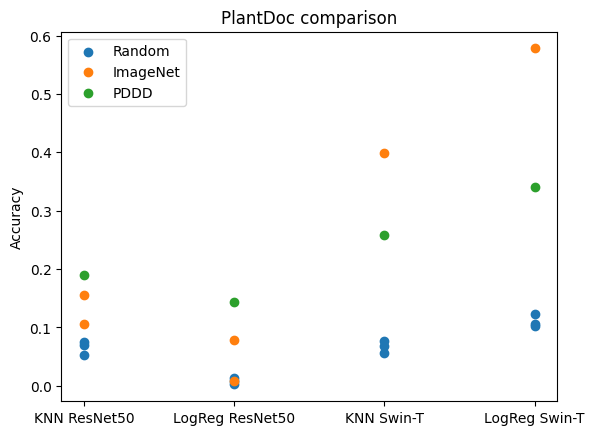

In [3]:
plt.scatter(x_values_random, y_values_random)
plt.scatter(x_values_imagenet, y_values_imagenet)
plt.scatter(x_values_pddd, y_values_pddd)
plt.gca().set_ylabel("Accuracy")  # gca = get current axes
plt.legend(["Random", "ImageNet", "PDDD"])
plt.title("PlantDoc comparison")
plt.show()

In [6]:
x_values_random = [
    "KNN ResNet50",
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "KNN Swin-T",
    "KNN Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
    "LogReg Swin-T",
]
y_values_random = [
    0.446064139941691,
    0.43440233236151604,
    0.43440233236151604,
    0.2944606413994169,
    0.32653061224489793,
    0.40233236151603496,
    0.45481049562682213,
    0.36151603498542273,
    0.40233236151603496,
    0.5451895043731778,
    0.4752186588921283,
    0.4956268221574344,
]
x_values_imagenet = [
    "KNN ResNet50",
    "KNN ResNet50",
    "LogReg ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_imagenet = [
    0.5714285714285714,
    0.565597667638484,
    0.2565597667638484,
    0.4897959183673469,
    0.5830903790087464,
    0.7346938775510204,
]
x_values_pddd = [
    "KNN ResNet50",
    "LogReg ResNet50",
    "KNN Swin-T",
    "LogReg Swin-T",
]
y_values_pddd = [
    0.4752186588921283,
    0.42565597667638483,
    0.6122448979591837,
    0.6384839650145773,
]

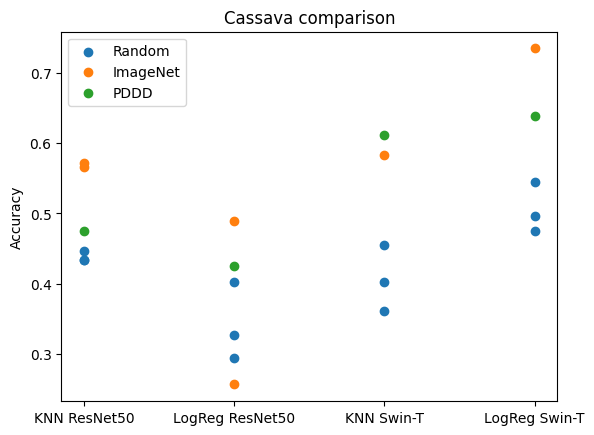

In [7]:
plt.scatter(x_values_random, y_values_random)
plt.scatter(x_values_imagenet, y_values_imagenet)
plt.scatter(x_values_pddd, y_values_pddd)
plt.gca().set_ylabel("Accuracy")  # gca = get current axes
plt.legend(["Random", "ImageNet", "PDDD"])
plt.title("Cassava comparison")
plt.show()